In [1]:
## Data Collection: Load csv files and check contents

import pandas as pd
import glob

# Set pandas option to display all columns
pd.set_option('display.max_columns', None)

# Define the path to your CSV files
csv_files = glob.glob('fuel_prices_*.csv')  # Assumes all files start with 'fuel_price_' and are in the current directory

# Load all CSV files into a list of DataFrames
df_list = [pd.read_csv(file) for file in csv_files]

# Concatenate all DataFrames into one DataFrame
df = pd.concat(df_list, ignore_index=True)

# Display the shape of the combined DataFrame to verify
print(df.shape)
print(df.head(5))
print(df.columns)

(469336, 12)
     SiteId         Site_Name Site_Brand Sites_Address_Line_1 Site_Suburb   
0  61401007  7-Eleven Coomera   7 Eleven      Pacific Highway     Coomera  \
1  61401007  7-Eleven Coomera   7 Eleven      Pacific Highway     Coomera   
2  61401007  7-Eleven Coomera   7 Eleven      Pacific Highway     Coomera   
3  61401007  7-Eleven Coomera   7 Eleven      Pacific Highway     Coomera   
4  61401007  7-Eleven Coomera   7 Eleven      Pacific Highway     Coomera   

  Site_State  Site_Post_Code  Site_Latitude  Site_Longitude       Fuel_Type   
0        QLD            4209     -27.868591      153.314206             e10  \
1        QLD            4209     -27.868591      153.314206             e10   
2        QLD            4209     -27.868591      153.314206             LPG   
3        QLD            4209     -27.868591      153.314206  Premium Diesel   
4        QLD            4209     -27.868591      153.314206     PULP 98 RON   

   Price TransactionDateutc  
0   1879   31/03/20

In [2]:
import pandas as pd

# Step 1: Ensure the TransactionDateutc in df is in datetime64[ns] format
df['TransactionDateutc'] = pd.to_datetime(df['TransactionDateutc'], errors='coerce')

# Normalize TransactionDateutc to midnight (00:00:00)
df['TransactionDateutc'] = df['TransactionDateutc'].dt.normalize()

# Step 2: Aggregate data by SiteId and TransactionDateutc to remove duplicates
df = df.groupby(['SiteId', 'TransactionDateutc']).agg({
    'Site_Name': 'first',       # Keep the first occurrence of the site name
    'Site_Brand': 'first',      # Keep the first occurrence of the brand
    'Sites_Address_Line_1': 'first',  # First occurrence of address
    'Site_Suburb': 'first',     # First occurrence of suburb
    'Site_State': 'first',      # First occurrence of state
    'Site_Post_Code': 'first',  # First occurrence of postcode
    'Site_Latitude': 'first',   # First occurrence of latitude
    'Site_Longitude': 'first',  # First occurrence of longitude
    'Fuel_Type': 'first',       # First occurrence of fuel type
    'Price': 'mean'             # Take the average price if there are multiple records
}).reset_index()

# Step 3: Get all unique SiteIds
all_site_ids = df['SiteId'].unique()

# Step 4: Create a full date range for weekly intervals and normalize it to midnight
full_weeks = pd.date_range(start=df['TransactionDateutc'].min(), 
                           end=df['TransactionDateutc'].max(), 
                           freq='W').normalize()

# Step 5: Create an empty DataFrame with all combinations of SiteId and Week
full_index = pd.MultiIndex.from_product([all_site_ids, full_weeks], names=['SiteId', 'TransactionDateutc'])
empty_df = pd.DataFrame(index=full_index).reset_index()

# Normalize TransactionDateutc in empty_df to midnight (though already normalized in this step)
empty_df['TransactionDateutc'] = pd.to_datetime(empty_df['TransactionDateutc']).dt.normalize()

# Step 6: Resample df first to match the weekly intervals, grouped by SiteId
df.set_index('TransactionDateutc', inplace=True)  # Set TransactionDateutc as index for resampling

# Resample weekly and forward fill, but avoid adding SiteId back twice
resampled_df = df.groupby('SiteId', group_keys=False).resample('W').ffill().reset_index(drop=False)

# Normalize TransactionDateutc in resampled_df to midnight to match empty_df
resampled_df['TransactionDateutc'] = resampled_df['TransactionDateutc'].dt.normalize()

# Step 7: Merge resampled df with empty_df
merged_df = pd.merge(empty_df, resampled_df, on=['SiteId', 'TransactionDateutc'], how='left')

# Step 8: Forward fill any remaining missing data (prices, brands, etc.)
merged_df = merged_df.groupby('SiteId').ffill()

# Step 9: Verify the structure of the resulting DataFrame
print(merged_df.head())

/var/folders/wz/zmc0gwmn2n57xys67hh2y13c0000gn/T/ipykernel_19415/441372422.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['TransactionDateutc'] = pd.to_datetime(df['TransactionDateutc'], errors='coerce')


  TransactionDateutc      Site_Name Site_Brand Sites_Address_Line_1   
0         2023-12-31            NaN        NaN                  NaN  \
1         2024-01-07            NaN        NaN                  NaN   
2         2024-01-14  Liberty Surat    Liberty   61 Burrowes Street   
3         2024-01-21  Liberty Surat    Liberty   61 Burrowes Street   
4         2024-01-28  Liberty Surat    Liberty   61 Burrowes Street   

  Site_Suburb Site_State  Site_Post_Code  Site_Latitude  Site_Longitude   
0         NaN        NaN             NaN            NaN             NaN  \
1         NaN        NaN             NaN            NaN             NaN   
2       Surat        QLD          4417.0     -27.151687      149.067742   
3       Surat        QLD          4417.0     -27.151687      149.067742   
4       Surat        QLD          4417.0     -27.151687      149.067742   

  Fuel_Type        Price  
0       NaN          NaN  
1       NaN          NaN  
2    Diesel  1965.666667  
3    Diesel  1

In [4]:
# Group by TransactionDateutc (week) and Site_Brand to count the number of sites for each brand
weekly_market_share = merged_df.groupby([merged_df['TransactionDateutc'], 'Site_Brand']).size().unstack(fill_value=0)

# Calculate the percentage market share for each brand
weekly_market_share_percentage = weekly_market_share.div(weekly_market_share.sum(axis=1), axis=0) * 100

# Check the results
print(weekly_market_share_percentage.head())

Site_Brand           7 Eleven      Ampol    Astron  Atlas Fuel         BP   
TransactionDateutc                                                          
2023-12-31          31.161972  29.225352  0.000000         0.0  16.373239  \
2024-01-07          15.445026  17.626527  0.436300         0.0  16.666667   
2024-01-14          12.872727  15.490909  0.581818         0.0  16.654545   
2024-01-21          11.919192  15.084175  0.538721         0.0  16.902357   
2024-01-28          11.515940  14.899154  0.520494         0.0  16.720885   

Site_Brand            Caltex    Choice  Coles Express    Costco   EG Ampol   
TransactionDateutc                                                           
2023-12-31          0.000000  0.000000       1.232394  0.000000  19.366197  \
2024-01-07          6.020942  0.087260       7.155323  0.261780   9.685864   
2024-01-14          6.618182  0.145455       9.672727  0.218182   8.072727   
2024-01-21          6.127946  0.134680       9.292929  0.202020   7.47

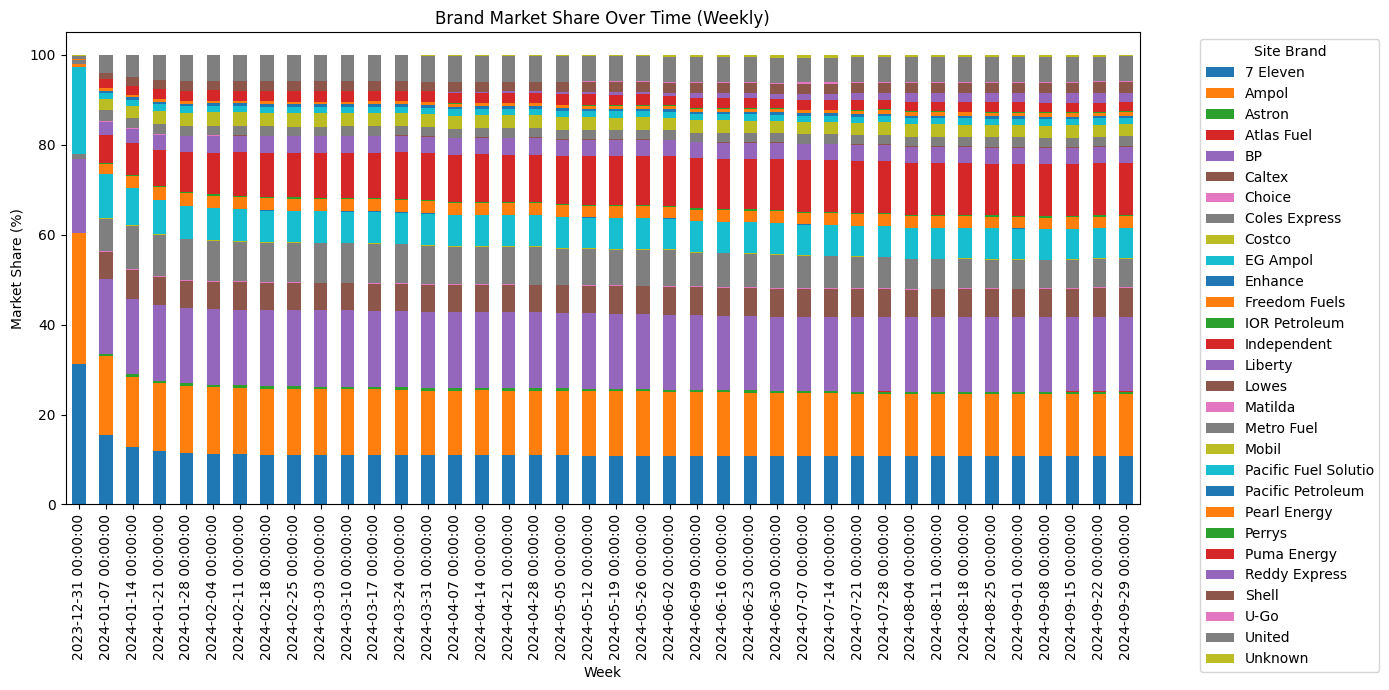

In [5]:
import matplotlib.pyplot as plt

# Plot the brand market share over time using a stacked bar chart
weekly_market_share_percentage.plot(kind='bar', stacked=True, figsize=(14, 7))

# Add titles and labels
plt.title('Brand Market Share Over Time (Weekly)')
plt.ylabel('Market Share (%)')
plt.xlabel('Week')
plt.legend(title='Site Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

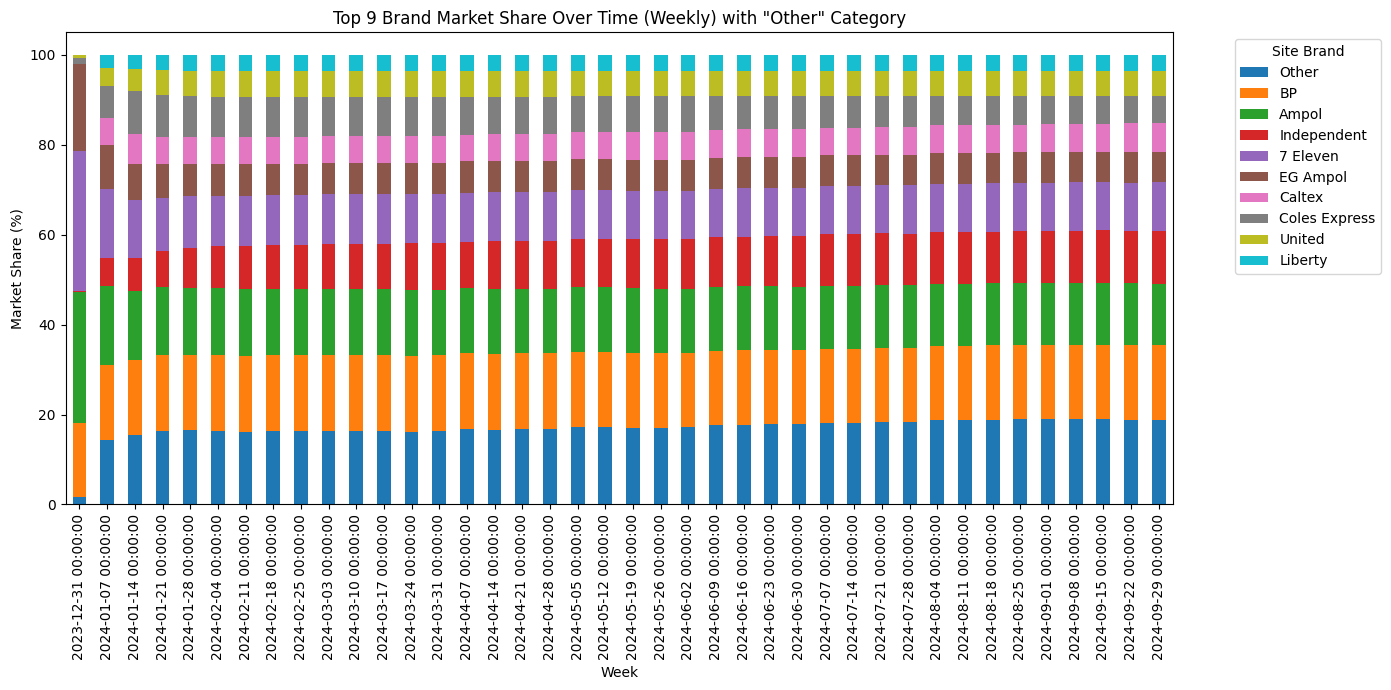

In [6]:
# Get the most recent week's top 9 brands by site count
most_recent_week = weekly_market_share.iloc[-1]
top_9_brands = most_recent_week.nlargest(9).index

# Create a new DataFrame for the top 9 brands and sum the rest as 'Other'
weekly_market_share_top_9 = weekly_market_share_percentage[top_9_brands].copy()
weekly_market_share_top_9['Other'] = weekly_market_share_percentage.drop(columns=top_9_brands).sum(axis=1)

# Sort the columns so that the largest brand is at the bottom
weekly_market_share_top_9 = weekly_market_share_top_9[top_9_brands.tolist() + ['Other']].sort_values(by=weekly_market_share_top_9.index[-1], axis=1, ascending=False)

# Plot the top 9 brands' market share over time
weekly_market_share_top_9.plot(kind='bar', stacked=True, figsize=(14, 7))

# Add titles and labels
plt.title('Top 9 Brand Market Share Over Time (Weekly) with "Other" Category')
plt.ylabel('Market Share (%)')
plt.xlabel('Week')
plt.legend(title='Site Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

In [7]:
# Group by week (TransactionDateutc) and Site_Brand to count the number of sites for each brand
weekly_site_count = merged_df.groupby([merged_df['TransactionDateutc'], 'Site_Brand']).size().unstack(fill_value=0)

# Calculate the percentage market share for each brand
weekly_market_share_percentage = weekly_site_count.div(weekly_site_count.sum(axis=1), axis=0) * 100

# Check the first few rows of both
print(weekly_site_count.head())
print(weekly_market_share_percentage.head())

Site_Brand          7 Eleven  Ampol  Astron  Atlas Fuel   BP  Caltex  Choice   
TransactionDateutc                                                             
2023-12-31               177    166       0           0   93       0       0  \
2024-01-07               177    202       5           0  191      69       1   
2024-01-14               177    213       8           0  229      91       2   
2024-01-21               177    224       8           0  251      91       2   
2024-01-28               177    229       8           0  257      92       3   

Site_Brand          Coles Express  Costco  EG Ampol  Enhance  Freedom Fuels   
TransactionDateutc                                                            
2023-12-31                      7       0       110        0              3  \
2024-01-07                     82       3       111        0             28   
2024-01-14                    133       3       111        1             37   
2024-01-21                    138       3   

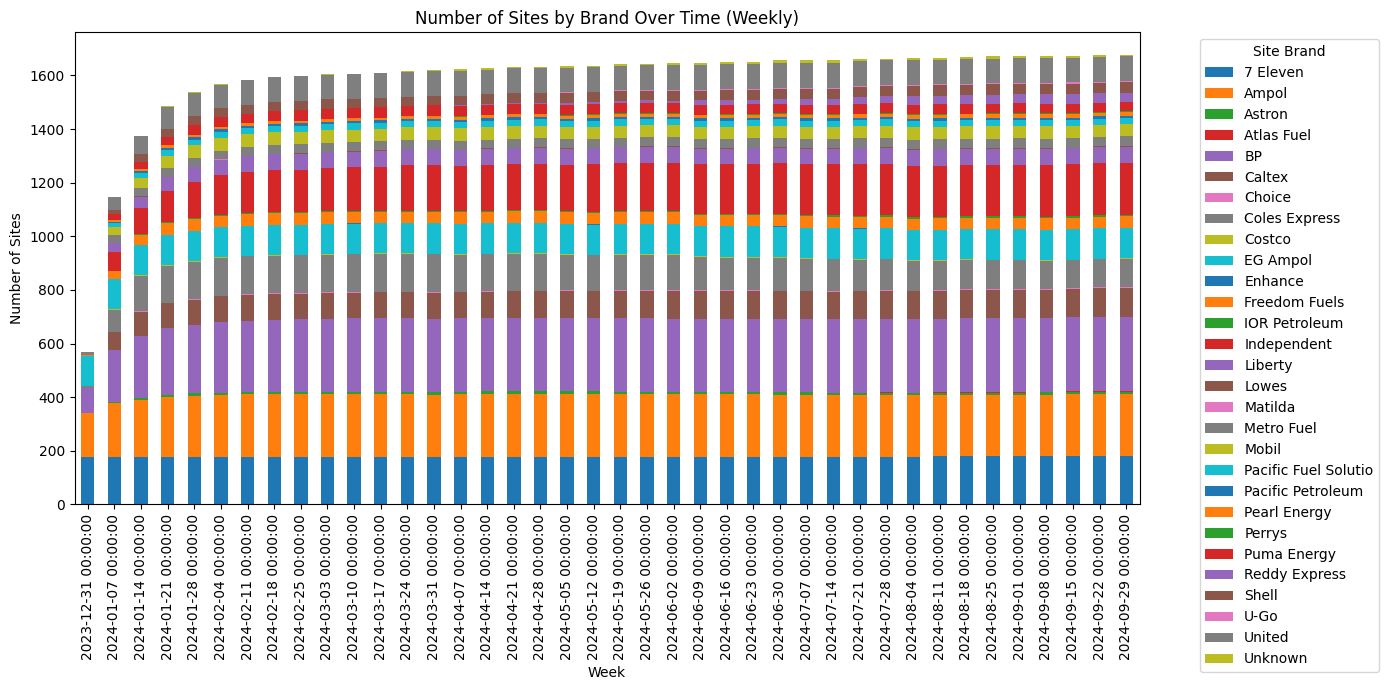

In [8]:
import matplotlib.pyplot as plt

# Plot the actual number of sites (stacked bar chart)
weekly_site_count.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Number of Sites by Brand Over Time (Weekly)')
plt.ylabel('Number of Sites')
plt.xlabel('Week')
plt.legend(title='Site Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

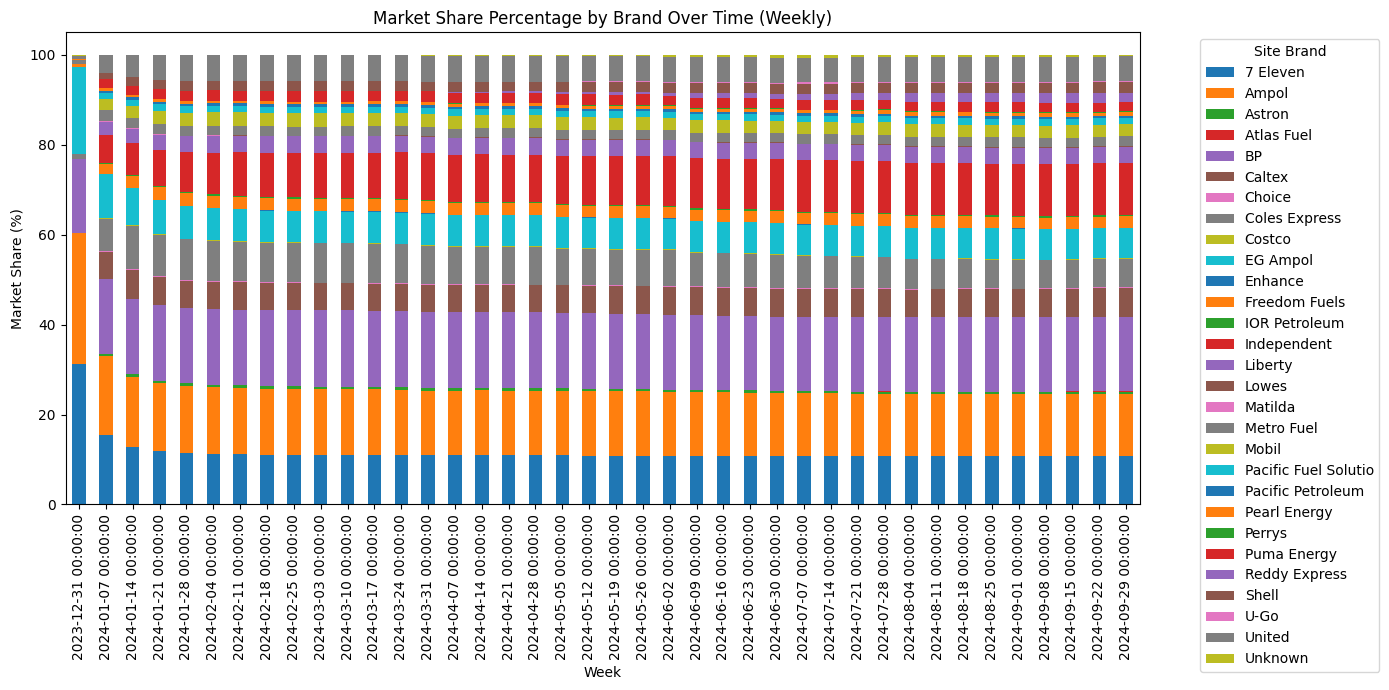

In [9]:
# Plot the market share percentage (stacked bar chart)
weekly_market_share_percentage.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Market Share Percentage by Brand Over Time (Weekly)')
plt.ylabel('Market Share (%)')
plt.xlabel('Week')
plt.legend(title='Site Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

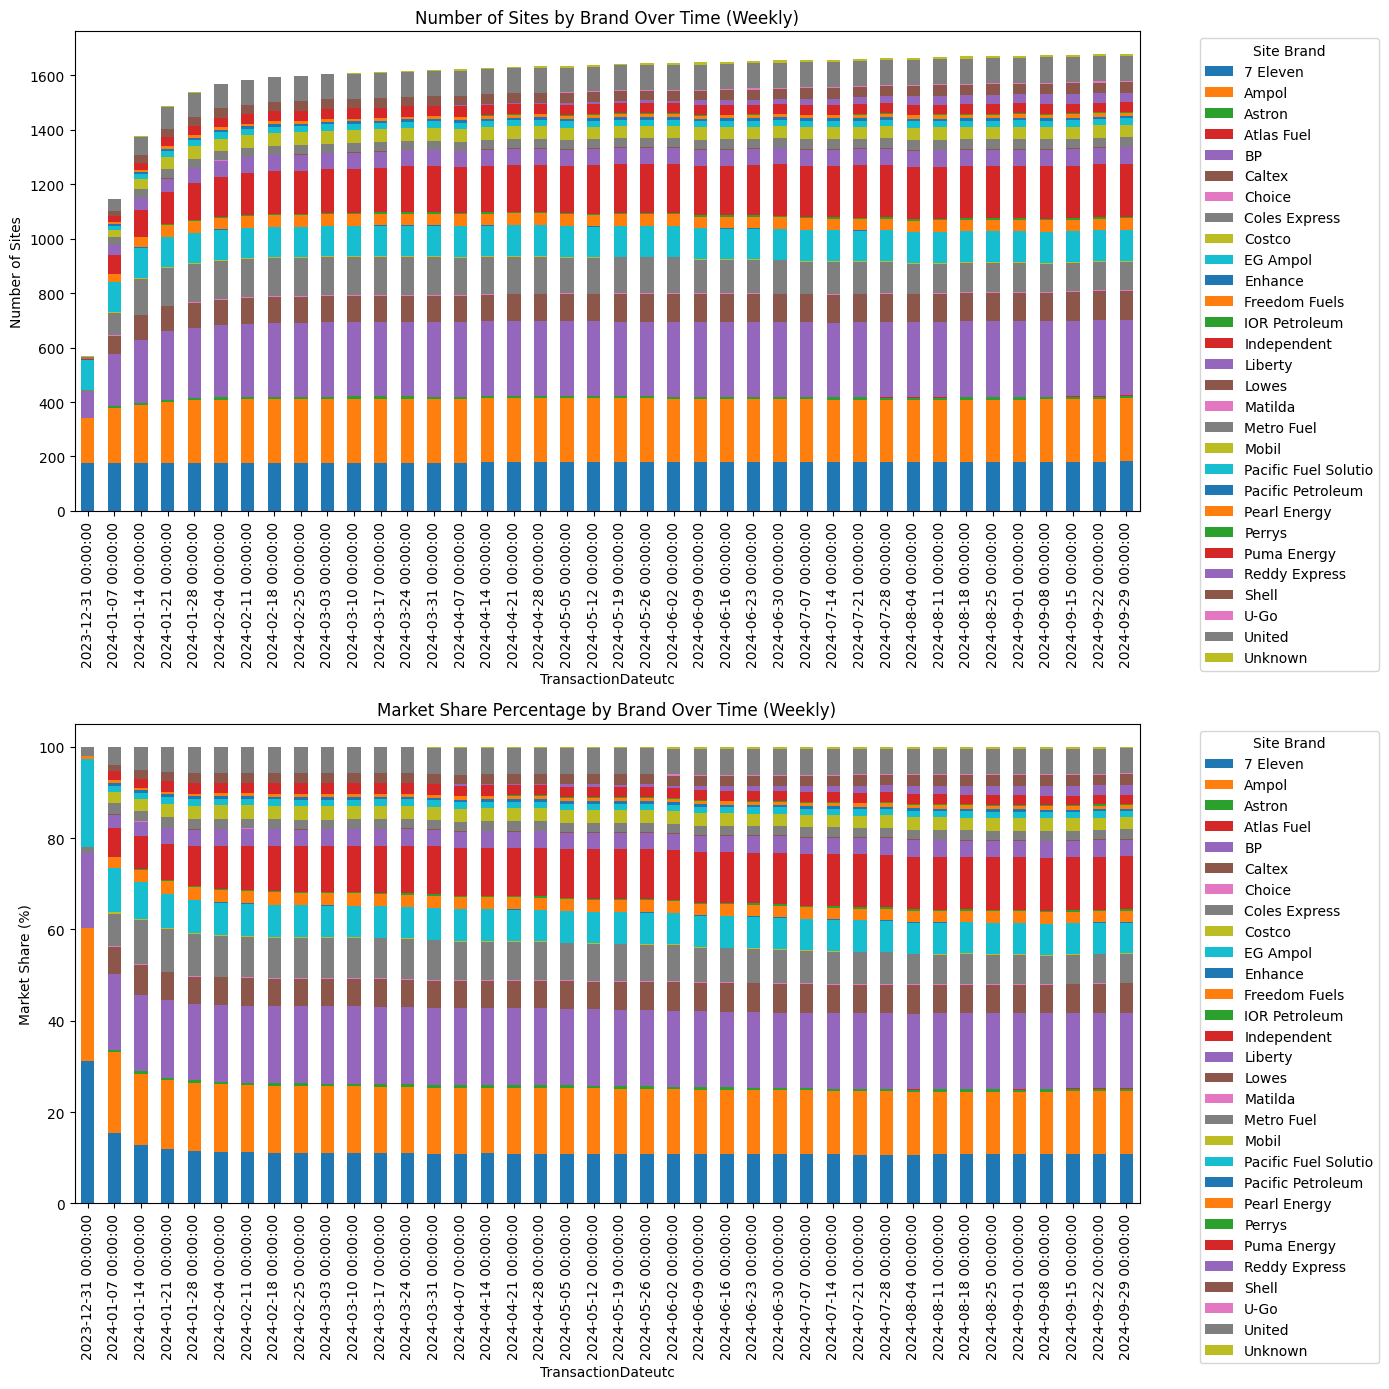

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(14, 14))

# Plot the actual number of sites
weekly_site_count.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Number of Sites by Brand Over Time (Weekly)')
axes[0].set_ylabel('Number of Sites')
axes[0].legend(title='Site Brand', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot the market share percentage
weekly_market_share_percentage.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Market Share Percentage by Brand Over Time (Weekly)')
axes[1].set_ylabel('Market Share (%)')
axes[1].legend(title='Site Brand', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [11]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# Assume weekly_site_count and weekly_market_share_percentage are pandas DataFrames

# Plot the actual number of sites (Stacked Bar)
fig_sites = px.bar(
    weekly_site_count,
    x=weekly_site_count.index,  # x-axis as the weekly dates
    y=weekly_site_count.columns,  # Stacking by brand
    title="Number of Sites by Brand Over Time (Weekly)",
    labels={"value": "Number of Sites", "x": "Week"},
)

# Update the layout for the number of sites chart
fig_sites.update_layout(
    barmode="stack",
    yaxis_title="Number of Sites",
    legend_title_text="Site Brand",
    xaxis_tickformat="%Y-%m-%d",  # Optional: format date on x-axis
    hovermode="x unified"  # Show hover info for all brands at once
)

# Plot the market share percentage (Stacked Bar)
fig_market_share = px.bar(
    weekly_market_share_percentage,
    x=weekly_market_share_percentage.index,  # x-axis as the weekly dates
    y=weekly_market_share_percentage.columns,  # Stacking by brand
    title="Market Share Percentage by Brand Over Time (Weekly)",
    labels={"value": "Market Share (%)", "x": "Week"},
)

# Update the layout for the market share percentage chart
fig_market_share.update_layout(
    barmode="stack",
    yaxis_title="Market Share (%)",
    legend_title_text="Site Brand",
    xaxis_tickformat="%Y-%m-%d",
    hovermode="x unified"  # Show hover info for all brands at once
)

# Display both charts
fig_sites.show()
fig_market_share.show()

In [12]:
import plotly.express as px
import pandas as pd

# Step 1: Identify top 10 brands by the total number of sites (sum across weeks)
top_10_brands = weekly_site_count.sum().nlargest(10).index

# Step 2: Filter the weekly_site_count and weekly_market_share_percentage for top 10 brands
weekly_site_count_top_10 = weekly_site_count[top_10_brands]
weekly_market_share_percentage_top_10 = weekly_market_share_percentage[top_10_brands]

# Step 3: Plot the actual number of sites (Stacked Bar for top 10 brands)
fig_sites_top_10 = px.bar(
    weekly_site_count_top_10,
    x=weekly_site_count_top_10.index,  # x-axis as the weekly dates
    y=weekly_site_count_top_10.columns,  # Stacking by brand (top 10)
    title="Number of Sites by Top 10 Brands Over Time (Weekly)",
    labels={"value": "Number of Sites", "x": "Week"},
)

# Update layout for the number of sites chart
fig_sites_top_10.update_layout(
    barmode="stack",
    yaxis_title="Number of Sites",
    legend_title_text="Site Brand",
    xaxis_tickformat="%Y-%m-%d",  # Optional: format date on x-axis
    hovermode="x unified"  # Show hover info for all brands at once
)

# Step 4: Plot the market share percentage (Stacked Bar for top 10 brands)
fig_market_share_top_10 = px.bar(
    weekly_market_share_percentage_top_10,
    x=weekly_market_share_percentage_top_10.index,  # x-axis as the weekly dates
    y=weekly_market_share_percentage_top_10.columns,  # Stacking by brand (top 10)
    title="Market Share Percentage by Top 10 Brands Over Time (Weekly)",
    labels={"value": "Market Share (%)", "x": "Week"},
)

# Update layout for the market share percentage chart
fig_market_share_top_10.update_layout(
    barmode="stack",
    yaxis_title="Market Share (%)",
    legend_title_text="Site Brand",
    xaxis_tickformat="%Y-%m-%d",
    hovermode="x unified"  # Show hover info for all brands at once
)

# Step 5: Display both charts
fig_sites_top_10.show()
fig_market_share_top_10.show()